In [2]:
import os
import sys

import numpy as np
import math
import numpy.linalg as LA
import numpy.matlib
import pandas as pd
import utils.wbpdn_lcurve as lc
import matplotlib.pylab as plt
from matplotlib import rc
rc('font', **{'family':'Times', 'size':13})
# rc('text', usetex=True)
rc('savefig', **{'transparent':False})


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from scipy.integrate import odeint
from sklearn.preprocessing import PolynomialFeatures
from scipy.linalg import lstsq

# ####### SPGL1 package #######
# from spgl1 import spg_bpdn
# # from spgl1.lsqr import lsqr
# # from spgl1 import spgl1, spg_lasso, spg_bp, spg_bpdn, spg_mmv
# # from spgl1.spgl1 import norm_l1nn_primal, norm_l1nn_dual, norm_l1nn_project
# # from spgl1.spgl1 import norm_l12nn_primal, norm_l12nn_dual, norm_l12nn_project

import cvxpy as cp

class Obj():
	def __init__(self):
		return

class FOLDER():
	def __init__(self):
		self.data = './data/duffing/'

		# self.post = './postprocessing/'
		# self.ex = './example/'

	def MakeDir(self):
		for k in self.__dict__.keys():
			myfile = self.__dict__[k]
			if isinstance(myfile, str) == True:
				if not os.path.exists(myfile):
					os.makedirs(myfile)

Folder = FOLDER()
Folder.MakeDir()

In [3]:
#####################################################################################
##### Dynamic systems
#####################################################################################
def duffing(x, t, gamma, kappa, epsilon):
	### Compute dynamics
	dsdt = [x[1], -gamma*x[1] - kappa*x[0] - epsilon*x[0]**3.]
	return dsdt

#####################################################################################
##### Parameters 
#####################################################################################
gamma = 0.1
kappa = 1.
epsilon = 5.
poly_order = 3  ##1, x, y, x^2, xy, y^2, x^3, x^2y, xy^2, y^3

x_initial = [0., 1.]
noise_scale = 0.01 ## constant to adjust the error scale 

t0, tf = 0, 2  # start and end
uniform_dt = 'yes'

In [4]:
#####################################################################################
##### Make true & noisy data using a dynamic model 
#####################################################################################
DATA = {}

##### Time instants 
if uniform_dt == 'yes':
	dt = 0.01  # time step
	Nt = int(np.floor(tf-t0)/dt + 1) #Number of time instances
	t_span = np.linspace(t0, tf, Nt)
else:
	Nt = 1000 ##the number of time instants
	t_span = np.sort(np.random.uniform(t0, tf, Nt)) ##Choose random time instants 

dt = np.diff(t_span) ##time step 
DATA['t'] = t_span
nsample = DATA['t'].shape[0]

##### Initial Conditions/Values
DATA['x:init'] =np.array(x_initial)
n_var = len(DATA['x:init'])

##### True data from a dynamic model
DATA['x:true'] = odeint(lambda x, t:duffing(x, t, gamma, kappa, epsilon), DATA['x:init'], t_span)
assert(DATA['x:true'].shape[1] == n_var)

##### True dx solutions in time 
DATA['dx:true'] = np.zeros(DATA['x:true'].shape)
for i in range(nsample):
	DATA['dx:true'][i] = duffing(DATA['x:true'][i], t_span[i], gamma, kappa, epsilon)
assert(np.sum(abs(DATA['x:true'][:,1] - DATA['dx:true'][:,0])) == 0.)

##### Corrupt states by adding noise --> Observation model x_noise(t) = x_true(t) + e(t)
Noise = {}
Noise['true'] = noise_scale*np.random.randn(Nt, n_var) ## Additive zero-mean white noise (Assumed Gaussian)
ti = 0
Noise['true'][ti] = 0.  ## Assume there is no noise at the initial time ti=0

DATA['x:noisy'] = DATA['x:true'] + Noise['true'] ## Add noise to the true data 

In [5]:
#####################################################################################
##### Algorithms
#####################################################################################

##### Subtract assumed(=initialized) noise from observations (= the first approximation for x_true)
DATA['x:approx'] = DATA['x:noisy']

##### Generate multi-variate Vandermonde matrix of degree poly_order in n variables
Poly = PolynomialFeatures(degree=poly_order)
Phi = {}
for i in ['true', 'approx']:
	Phi[i] = Poly.fit_transform(DATA['x:' + i])
P = Phi['approx'].shape[1] ## Number of basis functions
assert(P == math.factorial(poly_order+n_var)/math.factorial(poly_order)/math.factorial(n_var))

##### True coefficients
Coef = {}
Coef['true'] = np.zeros((P, n_var))
Coef['true'][2,0] = 1
Coef['true'][1,1] = -kappa
Coef['true'][2,1] = -gamma
Coef['true'][6,1] = -epsilon

In [6]:
#####################################################################################
##### Solve Equations for Coefficients (Integral formulationn + WBPDN)
#####################################################################################

##### Generate LHS and integral matrix of the integral formulation using simple quadrature
Xb_Xa = DATA['x:approx'] - np.matlib.repmat(DATA['x:init'], nsample, 1)# LHS
dt_mat = np.tile(dt.reshape(-1,1), (1, P)) ### Reshape for convenience

ninteg = nsample  ##the number of integrations "int_a^b phi_i(x) dt" = the number of (aj, bj) instants
if ((uniform_dt == 'yes') & (dt[0] == 0.0001)):
	Int_Phi = np.loadtxt('./data/Int_Phi_dt0.0001.txt')
else:
	Int_Phi = np.zeros((ninteg, P))
	for i in range(ninteg):
		Int_Phi[i] = np.sum(dt_mat[0:i]*Phi['approx'][0:i], axis=0)

##### Solve the coefficient with a regularized least-square problem 
##### "min 1/2|b - A*Coef|_2^2 + lambda * |Coef|_1"
Coef['bpdn'] = np.zeros((P, n_var)) ### basis pursuit denoising (BPDN)
num_itrs = 3
num_witrs = 3
q = 2
eps_w = 0.0001

# for itr in range(num_itrs):
for witr in range(num_witrs):  
    
    if witr == 0:
        w = None
    else:
        w = 1 / (np.abs(Coef['bpdn'][:,i]) ** 2 + eps_w)
        
    for i in range(n_var):
        b = Xb_Xa[:,i]
        A = Int_Phi
        #wbpdn_flc = lc.full_lcurve(A, b, lambda_min = 1e-12, lambda_max = 1e3, n_lambdas = 100, normalize = True, plot_lc = True)
        wbpdn_c = lc.lcurve_corner(A, b, w=w, lambda_min = 1e-12, lambda_max = 1e3)
        Coef['bpdn'][:,i] = wbpdn_c[0]

lambda_max too large. Reducing it 10 times...
lambda_max too large. Reducing it 10 times...
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 20 iterations.
lambda_max too large. Reducing it 10 times...
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 19 iterations.
lambda_max too large. Reducing it 10 times...
  Convergence criterion reached in 20 iterations.
  Convergence criterion reached in 20 iterations.


In [7]:
#Print coefficients using integral formulation + WBPDN
beta = Coef['bpdn']
beta[np.abs(beta) < 0.01] = 0
print(beta)

[[ 0.          0.        ]
 [ 0.         -1.03063252]
 [ 0.99296709 -0.09353263]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-0.03799793 -4.91696307]
 [ 0.04114095 -0.13097442]
 [ 0.          0.        ]
 [ 0.          0.        ]]


lambda_max too large. Reducing it 10 times...
lambda_max too large. Reducing it 10 times...
lambda_max too large. Reducing it 10 times...
lambda_max too large. Reducing it 10 times...
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 20 iterations.
[[-7.72381585e-09 -2.15102375e-05]
 [-3.75732023e-08 -9.35944123e-01]
 [ 9.85323833e-01 -9.09224344e-02]
 [-1.53378427e-07 -2.04490004e-01]
 [ 3.81983898e-02  1.34592097e-07]
 [-8.37205964e-10 -1.28400416e-02]
 [-3.56453019e-02 -4.82807187e+00]
 [ 5.07993836e-07 -1.40299941e-01]
 [-1.23346379e-08 -2.17759122e-05]
 [ 1.39063217e-05 -1.79267099e-06]]
lambda_max too large. Reducing it 10 times...
lambda_max too large. Reducing it 10 times...
lambda_max too large. Reducing it 10 times...
lambda_max too large. Reducing it 10 times...
  Convergence criterion reached in 20 iterations.
  Convergence criterion reached in 10 iterations.
[[-8.19176280e-03 -5.81788870e-03]
 [-3.40225346e-06 -9.36596263e-01]
 [ 9.245982

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


  Convergence criterion reached in 18 iterations.
[[-1.82639707e-03 -5.55914785e-03]
 [ 2.71436633e-08 -8.60229836e-01]
 [ 9.41307366e-01 -7.81275014e-02]
 [-8.50803400e-05 -8.21128727e-02]
 [ 1.07100881e-02  7.62666736e-03]
 [-5.38764529e-03 -6.34345874e-04]
 [-3.10221496e-02 -5.16429650e+00]
 [ 1.36019908e-01 -1.88300568e-01]
 [ 1.59192594e-02 -1.28636680e-01]
 [ 5.05815824e-02 -1.43057502e-02]]


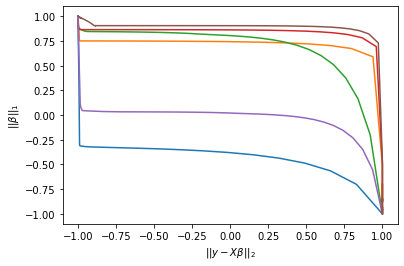

In [8]:
#####################################################################################
##### Solve Equations for Coefficients (integral formulation with iterative denoising)
#####################################################################################

##### Generate LHS and integral matrix of the integral formulation using simple quadrature
Xb_Xa = DATA['x:approx'] - np.matlib.repmat(DATA['x:init'], nsample, 1)# LHS
dt_mat = np.tile(dt.reshape(-1,1), (1, P)) ### Reshape for convenience

ninteg = nsample  ##the number of integrations "int_a^b phi_i(x) dt" = the number of (aj, bj) instants
if ((uniform_dt == 'yes') & (dt[0] == 0.0001)):
	Int_Phi = np.loadtxt('./data/Int_Phi_dt0.0001.txt')
else:
	Int_Phi = np.zeros((ninteg, P))
	for i in range(ninteg):
		Int_Phi[i] = np.sum(dt_mat[0:i]*Phi['approx'][0:i], axis=0)

##### Solve the coefficient with a regularized least-square problem 
##### "min 1/2|b - A*Coef|_2^2 + lambda * |Coef|_1"
Coef['bpdn'] = np.zeros((P, n_var)) ### basis pursuit denoising (BPDN)
num_itrs = 3

for itr in range(num_itrs):
        
    for i in range(n_var):
        b = Xb_Xa[:,i]
        A = Int_Phi
        wbpdn_flc = lc.full_lcurve(A, b, lambda_min = 1e-12, lambda_max = 1e3, n_lambdas = 100, normalize = True, plot_lc = True)
        wbpdn_c = lc.lcurve_corner(A, b, w=None, lambda_min = 1e-12, lambda_max = 1e3)
        Coef['bpdn'][:,i] = wbpdn_c[0]
    
    print(Coef['bpdn'])
    
    #Update DATA and LHS
    DATA['x:approx'] = DATA['x:init'] + np.dot(Int_Phi, Coef['bpdn']) 
    Xb_Xa = np.dot(Int_Phi, Coef['bpdn']) 
    
    #Update int_Phi matrix - Evaluate basis at the denoised states
    Phi['approx'] = Poly.fit_transform(DATA['x:approx'])
    for i in range(ninteg):
        Int_Phi[i] = np.sum(dt_mat[0:i]*Phi['approx'][0:i], axis=0)

In [9]:
beta = Coef['bpdn']
beta[np.abs(beta) < 0.01] = 0

print(beta)

[[ 0.          0.        ]
 [ 0.         -0.86022984]
 [ 0.94130737 -0.0781275 ]
 [ 0.         -0.08211287]
 [ 0.01071009  0.        ]
 [ 0.          0.        ]
 [-0.03102215 -5.1642965 ]
 [ 0.13601991 -0.18830057]
 [ 0.01591926 -0.12863668]
 [ 0.05058158 -0.01430575]]


In [ ]:
##### Calculate approximation for dx from the coefficients achieved
	DATA['dx:'] = np.zeros(DATA['dx:true'].shape)
	for i in range(n_var):
		DATA['dx:'][:,i] = np.dot(Phi['approx'],  Coef['bpdn'][:,i])

Text(0, 0.5, 'coefficient value')

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


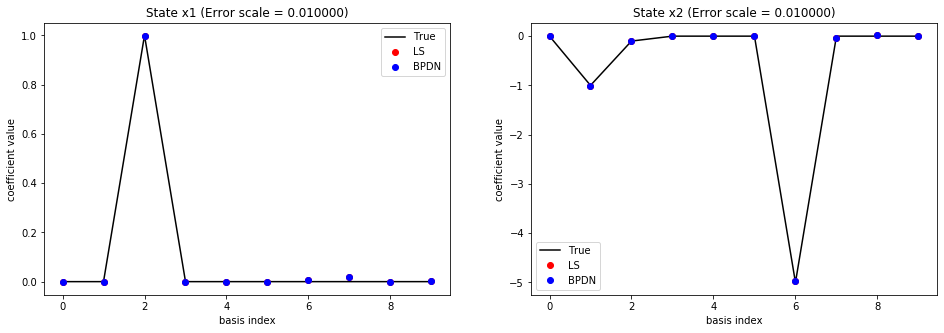

In [8]:
##### Plot: Compare coefficients 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,5))
ax1.plot(Coef['true'][:,0],'k')
ax1.plot(Coef['ls'][:,0],'ro')
ax1.plot(Coef['bpdn'][:,0],'bo')
ax1.legend(('True','LS','BPDN'))
ax1.set_title('State x1 (Error scale = {:f})'.format(noise_scale))
ax1.set_xlabel('basis index')
ax1.set_ylabel('coefficient value')

ax2.plot(Coef['true'][:,1],'k')
ax2.plot(Coef['ls'][:,1],'ro')
ax2.plot(Coef['bpdn'][:,1],'bo')
ax2.legend(('True','LS','BPDN'))
ax2.set_title('State x2 (Error scale = {:f})'.format(noise_scale))
ax2.set_xlabel('basis index')
ax2.set_ylabel('coefficient value')

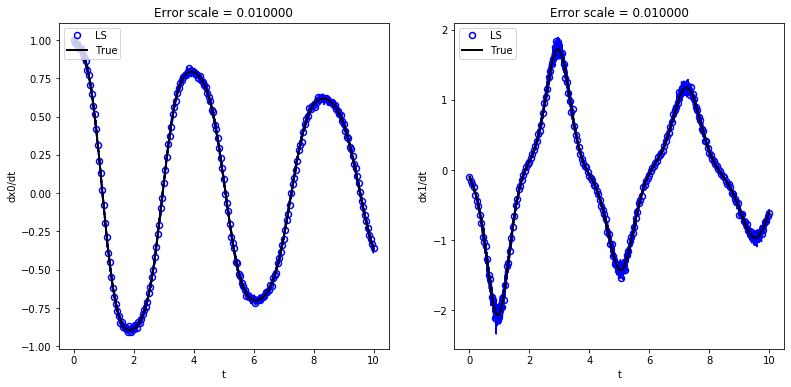

In [9]:
##### Plot: Compare dx/dt solutions from different coefficient solutions
ax = {}
fig, (ax[0], ax[1]) = plt.subplots(1, 2, figsize=(13,6))

for i in range(n_var):
	for method in ['ls']:#, 'bpdn']:
		cc = {'ls':'b', 'bpdn':'r', 'dnn':'g'}[method]
		mk = {'ls':'o', 'bpdn':'x', 'dnn':'o'}[method]
		ax[i].plot(t_span, DATA['dx:'+method][:,i], cc+'-', lw=1.5)
		jump = 50
		ax[i].plot(t_span[::jump], DATA['dx:'+method][:,i][::jump], cc+mk, label=method.upper(), mew=1.5, mfc='none')
	ax[i].plot(t_span, DATA['dx:true'][:,i], 'k-', label='True', lw=2)

	ax[i].set_xlabel('t')
	ax[i].set_ylabel('dx{:d}/dt'.format(i))
	ax[i].set_title('Error scale = {:f}'.format(noise_scale))
	ax[i].legend(loc='upper left', borderpad=0.3)

plt.show()

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


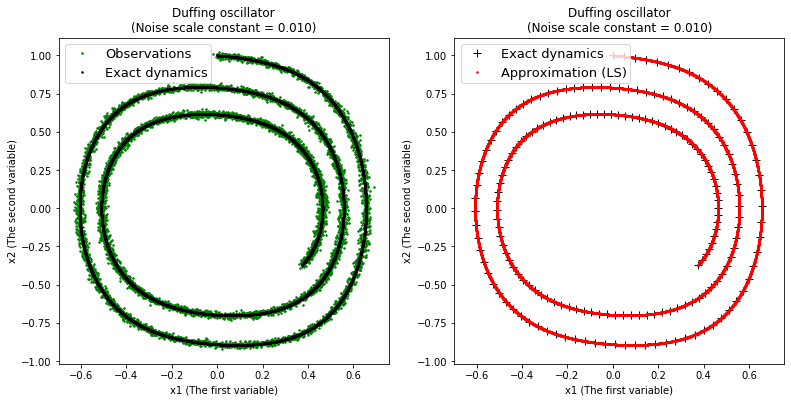

In [10]:
######################################################################################################
###### Plot: dynamic responses 
for method in ['ls', 'bpdn']:
	DATA['x:approx:'+method] = DATA['x:init'] + np.dot(Int_Phi, Coef[method]) 
######################################################################################################


ax = {}
fig, (ax[0], ax[1]) = plt.subplots(1, 2, figsize=(13,6))

############################
i = 0
ref = DATA['x:true']
approx = DATA['x:noisy']

ax[i].plot(approx[:,0], approx[:,1], 'g.', label='Observations', ms=3)
ax[i].plot(ref[:,0], ref[:,1], 'k.', label='Exact dynamics', ms=3)

############################
i = 1
method = ['ls', 'bpdn'][0]
approx = DATA['x:approx:'+method]

jump = 50
ax[i].plot(ref[:,0][::jump], ref[:,1][::jump], 'k+', ms=8, label='Exact dynamics')
ax[i].plot(approx[:,0], approx[:,1], 'r.', ms=3,\
	label='Approximation ({:s})'.format(method.upper()))

xLim = ax[0].get_xlim()
yLim = ax[0].get_ylim()
for i in range(2):
	ax[i].set_xlim(xLim)
	ax[i].set_ylim(yLim)
	ax[i].legend(loc='upper left', borderpad=0.25, fontsize=13)
	ax[i].set_title('Duffing oscillator\n(Noise scale constant = {:1.3f})'.format(noise_scale))
	ax[i].set_ylabel('x2 (The second variable)')
	ax[i].set_xlabel('x1 (The first variable)')

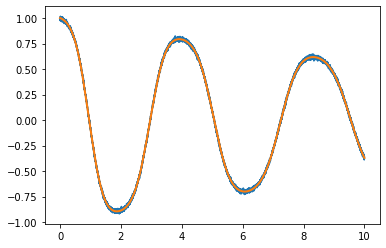

In [11]:
###### Plot: dx/dt
method = ['ls', 'bpdn'][1]
approx = DATA['x:approx:'+method]

dxdt = {}
for i in range(n_var):
	y = approx[:,0]
	dxdt[i] = (y[1:] - y[:-1])/dt

ig, ax = plt.subplots()
t_mid = (t_span[1:] + t_span[:-1])/2.

ax.plot(t_mid, dxdt[0])
ax.plot(t_span, approx[:,1], lw=2)
# ax.plot(t_span[1:-1], dxdt[1])

####################################################################################
plt.show()